# HAN 모델 새로 학습 원하는 경우 실행
## 2-1번 코드 수정 발생 시, 해당 코드 전체 실행 필수

In [2]:
import tensorflow as tf
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [4]:
# Package Load
import pandas as pd
import numpy as np
import pickle
from eunjeon import Mecab
import os
import collections
import re
from tqdm import tqdm
import nltk

# 다른 형태소 분석기를 사용하게 될 경우 수정 필요
mecab = Mecab(dicpath = 'C:\\mecab\\mecab-ko-dic') ## dic 반영 형태소 분석기

from collections import defaultdict
from collections import Counter
import re 
import sys
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Activation 
from keras.layers import Conv1D, MaxPooling1D, merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.models import Model 

from keras import optimizers
from keras import backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.python.keras.layers import Layer,InputSpec
from keras import initializers as initializers, regularizers, constraints

import json

from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import os 
from keras.models import load_model
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
version_name=str(datetime.today().strftime("%Y%m%d")) # 버전 담는 변수 (오늘의 날짜)

# Part 1. Classification Model Training 

### (1) 학습에 사용할 NTIS 로드 및 전처리

#### 사용자명, 불러올 NTIS 데이터명 입력 (사용자별 폴더 생성)

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [15]:
os.chdir("C:\\Users\\newcomer02\\NTIS_Project")

In [19]:
user_name = input("사용자명을 설정해주세요 : ")

data_ver = input("\n불러오실 NTIS 데이터명을 입력하세요 (Default : 엔터키): ")

사용자명을 설정해주세요 :  

불러오실 NTIS 데이터명을 입력하세요 (Default : 엔터키):  NTIS_2021


In [20]:
# 기존 NTIS data load 
# input : pkl 파일, 없으면 오류 (data 폴더에 존재)

if data_ver =='':
    with open('./data/Default/NTIS.pkl', 'rb') as f:
        labeled_data = pickle.load(f)
else:
    with open('./data/Default/NTIS/'+data_ver+'.pkl', 'rb') as f:
        labeled_data = pickle.load(f) 

if 'filtered_ICT' in labeled_data.columns:
    del labeled_data['filtered_ICT']

In [5]:
temp = []
for i in tqdm(range(len(labeled_data))) :
    if ((labeled_data['L_type_1'][i]=="정보/통신") | (labeled_data['L_type_2'][i]=="정보/통신") | 
        (labeled_data['L_type_3'][i]=="정보/통신") | (labeled_data['M_L_type'][i]=="ICT·SW")| 
        (labeled_data['AP_1'][i]=="출판, 영상, 방송통신 및 정보서비스업") | (labeled_data['AP_2'][i]=="출판, 영상, 방송통신 및 정보서비스업")|
        (labeled_data['AP_3'][i]=="출판, 영상, 방송통신 및 정보서비스업") | (labeled_data['6T_L_type'][i]=="IT(정보기술)")):
        temp.append(1)
    else :
        temp.append(0)
labeled_data['label'] = temp

100%|███████████████████████████████████████████████████████████████████████| 286028/286028 [00:09<00:00, 31128.81it/s]


In [6]:
from eunjeon import Mecab
mecab = Mecab(dicpath = 'C:\\mecab\\mecab-ko-dic')
print(mecab.pos("ict iot ai atml automl 안녕 직생하다 모르겠다 장의사"))
print(mecab.nouns("ict iot ai atml automl 안녕 직생하다 모르겠다 장의사"))


[('ict', 'SL'), ('iot', 'SL'), ('ai', 'SL'), ('atml', 'SL'), ('automl', 'SL'), ('안녕', 'IC'), ('직생하다', 'NNP'), ('모르', 'VV'), ('겠', 'EP'), ('다', 'EC'), ('장의사', 'NNP')]
['직생하다', '장의사']


In [11]:
def nouns(text):
    answer = list()
    target = ["NNG","NNP","NNB","NR","NP","SL"]
    for i in mecab.pos(text):
        if i[1] in target:
            answer.append(i[0])
        else: 
            continue
    return answer
nouns("ict iot ai atml automl 안녕 직생하다 모르겠다 장의사")

['ict', 'iot', 'ai', 'atml', 'automl', '직생하다', '장의사']

In [12]:
from nltk.tokenize import LineTokenizer

line_tokenizer = LineTokenizer()

def preprocessing(text_list):
    preprocessed_text = []
    for text in text_list:
        text = re.sub(r'\W+', ' ', text) 
        text = re.sub('o','', text)
        text = re.sub('○','', text)
        text = re.sub('ㅇ','', text)
        text = nouns(text)
        preprocessed_text.append(text)
    return preprocessed_text

def preprocessing_1(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub('o','', text)
    text = re.sub('○','', text)
    text = re.sub('ㅇ','', text)
    return text

def preprocessing_2(text):
    text = re.sub(r'\W+', ' ', text)
    text = re.sub('o','', text)
    text = re.sub('○','', text)
    text = re.sub('ㅇ','', text)
    text = nouns(text)
    return text

In [13]:
# for drop 컬럼 : 중복 데이터 제거를 위한 전처리 
# 실행 시 다소 긴 소요 시간 발생 유의

labeled_data['for drop'] = labeled_data['contents'].apply(lambda text: preprocessing_1(text))
#labeled_data = labeled_data.drop_duplicates(['for drop'], keep='first', ignore_index=True)

# filtered ICT 컬럼 : 생성한 필터워드 기반 ICT 레이블링 
# cleaned data 컬럼 : HAN 인풋을 위한 데이터 전처리 
# 실행 시 다소 긴 소요 시간 발생 유의

labeled_data['cleaned_data'] = labeled_data['contents'].apply(lambda text: line_tokenizer.tokenize(text))
labeled_data.cleaned_data = labeled_data.cleaned_data.apply(preprocessing)
labeled_data['for tokenizer'] = labeled_data['contents'].apply(preprocessing_2)

In [ ]:
# 워드 필터링 기반 레이블링 후, ICT  및 non ICT 문서 비율 
# 최종 ntis 데이터 저장

#labeled_data.to_pickle("./data/HAN/NTIS/LABELED_NTIS_2021_2.pkl")
labeled_data = pd.read_pickle("./data/Default/NTIS/LABELED_NTIS_2021.pkl")

In [3]:
## 데이터 구분(ict/non ict)
ict_doc = labeled_data[(labeled_data.label == 1)] 
non_ict_doc = labeled_data[(labeled_data.label == 0)]

### (3) HAN: 모델 학습 및 저장

In [4]:
DIC = pd.read_csv('./data/Default/user-custom.csv')
#ICT_DIC = pd.read_csv('./data/Default/ICT_DIC.csv',encoding="CP949")
#list_ICT_DIC = list(ICT_DIC['term'])
#list_ICT_DIC

In [5]:
# HAN 모델 학습 전 파라미터값 설정
# [문서, 문장, 단어]를 계층적으로 표현하기 위해 담을 Data Shape 구성

max_sent_length= 150 # 문장 내 최대 단어 수 
max_sentences = 30  # 문서 내 최대 문장 수 
max_words_dic = 25000
embedding_dim = 50 
adam = optimizers.Adam(learning_rate=0.001) 

# 단어 단위 토큰화 작업
# input : json 형태의 파일, 해당 파일 없으면 오류 발생 (data/HAN 폴더)
tokenizer = Tokenizer(num_words=max_words_dic, lower=False, oov_token="term")
tokenizer.word_index = dict.fromkeys(DIC['term'])

In [6]:
new_dict = {}
k=1
for v in tokenizer.word_index.keys():
    new_dict[v] = k
    k = k+1
    
tokenizer.word_index = new_dict 

In [7]:
len(tokenizer.word_index)

1064754

In [8]:
# HAN 모델 학습을 위한 전 단계

texts_ict = list(ict_doc['for tokenizer']) 
documents_ict = list(ict_doc.cleaned_data)
temp = {"label_0" : [0]*len(texts_ict),
        "label_1" : [1]*len(texts_ict)}
labels_ict = pd.DataFrame(temp)
word_dic = tokenizer.word_index
data_ict = np.zeros((len(texts_ict), max_sentences, max_sent_length), dtype='int32') 
data_ict.shape

(61323, 30, 150)

In [9]:
# HAN 모델 학습을 위한 전 단계

texts_non_ict = list(non_ict_doc['for tokenizer']) 
documents_non_ict = list(non_ict_doc.cleaned_data)
temp = {"label_0" : [1]*len(texts_non_ict),
        "label_1" : [0]*len(texts_non_ict)}
labels_non_ict = pd.DataFrame(temp)
word_dic = tokenizer.word_index
data_non_ict = np.zeros((len(texts_non_ict), max_sentences, max_sent_length), dtype='int32') 
data_non_ict.shape

(224705, 30, 150)

In [ ]:
61323 + 224705

286028

In [10]:
# 데이터 구성 : [문서, 문장, 단어]

for i, sentences in tqdm(enumerate(documents_ict)): # 문장 집합으로 표현된 하나의 문서를 뽑아서
    for j, sentence in enumerate(sentences): # 그 문서집합 내의 문장들을 하나씩 뽑고 
        if j < max_sentences:
            wordTokens = text_to_word_sequence(str(sentence))
            k = 0 
            for _, word in enumerate(wordTokens):
                try:
                    word = word.strip('\'')
                    if k < max_sent_length :
                        if word not in tokenizer.word_index:
                            continue
                        else :
                            data_ict[i,j,k] = tokenizer.word_index[word]
                            k+=1
                    
                except SyntaxError:
                    print(word)
                    if k < max_sent_length :
                        if word not in tokenizer.word_index:
                            continue
                        else :
                            data_ict[i,j,k] = tokenizer.word_index[word]
                            k+=1
  

61323it [00:26, 2341.38it/s]


In [21]:
data_ict

array([[[   1403,   19165,  720152, ...,       0,       0,       0],
        [1028580,  606939,  139000, ...,       0,       0,       0],
        [ 553097,  703508,  650114, ...,       0,       0,       0],
        ...,
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0]],

       [[  75122,  139000,  786034, ...,       0,       0,       0],
        [ 786034,  310280,  376703, ...,       0,       0,       0],
        [ 406122,  998717,   78524, ...,       0,       0,       0],
        ...,
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0]],

       [[1043450,  644053,   48958, ...,       0,       0,       0],
        [ 871517,  233115,  989037, ...,       0,       0,       0],
    

In [11]:
# 데이터 구성 : [문서, 문장, 단어]

for i, sentences in tqdm(enumerate(documents_non_ict)): # 문장 집합으로 표현된 하나의 문서를 뽑아서
    for j, sentence in enumerate(sentences): # 그 문서집합 내의 문장들을 하나씩 뽑고 
        if j < max_sentences:
            wordTokens = text_to_word_sequence(str(sentence))
            k = 0 
            for _, word in enumerate(wordTokens):
                try:
                    word = word.strip('\'')
                    if k < max_sent_length :
                        if word not in tokenizer.word_index:
                            continue
                        else :
                            data_non_ict[i,j,k] = tokenizer.word_index[word]
                            k+=1
                    
                except SyntaxError:
                    print(word)
                    if k < max_sent_length :
                        if word not in tokenizer.word_index:
                            continue
                        else :
                            data_non_ict[i,j,k] = tokenizer.word_index[word]
                            k+=1

224705it [01:22, 2737.22it/s]


In [22]:
data_non_ict

array([[[ 343009, 1043559,  677542, ...,       0,       0,       0],
        [ 454389,  132338,  734883, ...,       0,       0,       0],
        [ 597157, 1044268,  713812, ...,       0,       0,       0],
        ...,
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0]],

       [[ 396230, 1053468,  703508, ...,       0,       0,       0],
        [ 396230, 1053468,  731743, ...,       0,       0,       0],
        [ 396230, 1053468,  731743, ...,       0,       0,       0],
        ...,
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0],
        [      0,       0,       0, ...,       0,       0,       0]],

       [[ 142175, 1016054,   93823, ...,       0,       0,       0],
        [ 628204,  766338,  801597, ...,       0,       0,       0],
    

In [12]:
import random

random.seed(42)
ict_index = random.sample(range(len(ict_doc)), len(ict_doc))
non_ict_index = random.sample(range(len(non_ict_doc)), len(non_ict_doc))

ict_train_index = ict_index[:int(len(ict_index)*0.5)]
non_ict_train_index = non_ict_index[:int(len(non_ict_index)*0.5)]
ict_val_index = ict_index[int(len(ict_index)*0.5):int(len(ict_index)*0.8)]
non_ict_val_index = non_ict_index[int(len(non_ict_index)*0.5):int(len(non_ict_index)*0.8)]
ict_test_index = ict_index[int(len(ict_index)*0.8):]
non_ict_test_index = non_ict_index[int(len(non_ict_index)*0.8):]

In [13]:
ict_train_index_2 = random.choices(ict_train_index,k=len(non_ict_train_index)) 

In [14]:
# 학습하기 위한 데이터 형태 변환

def dot_product(x, kernel):
    return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)


class AttentionWithContext(Layer):
    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None,
                W_constraint=None, u_constraint=None, b_constraint=None, bias=True, **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init, 
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.init, 
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
    


In [15]:
x_train = data_ict[ict_train_index_2]
x_train=np.append(x_train, np.array(data_non_ict[non_ict_train_index]),axis=0)
x_val = data_ict[ict_val_index]
x_val=np.append(x_val, np.array(data_non_ict[non_ict_val_index]),axis=0)
x_test = data_ict[ict_test_index]
x_test=np.append(x_test, np.array(data_non_ict[non_ict_test_index]),axis=0)

y_train = labels_ict.iloc[ict_train_index_2,:]
y_train= np.append(y_train, np.array(labels_non_ict.iloc[non_ict_train_index,:]),axis=0)
y_val = labels_ict.iloc[ict_val_index,:]
y_val= np.append(y_val, np.array(labels_non_ict.iloc[non_ict_val_index,:]),axis=0)
y_test = labels_ict.iloc[ict_test_index,:]
y_test= np.append(y_test, np.array(labels_non_ict.iloc[non_ict_test_index,:]),axis=0)

In [16]:
random.seed(42)
new_train_index = random.sample(range(len(x_train)), len(x_train))

x_train_2 = x_train[new_train_index]
y_train_2 = y_train[new_train_index]

In [17]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print('Number of samples of each class in training and validation set')
print(y_train.sum(axis=0))

data_X = [x_train_2, x_val] 
data_y = [y_train_2, y_val] 

(224704, 30, 150)
(85809, 30, 150)
(57206, 30, 150)
Number of samples of each class in training and validation set
[112352 112352]


In [19]:
import tensorflow as tf
import random 
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# HAN 모델링 함수
def run_model(data_x, data_y, max_sentences, max_sent_length):
    

    #os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    #os.putenv('TF_GPU_ALLOCATOR', 'cuda_malloc_async')
    #os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    #os.environ["PYTHONHASHSEED"] = str(42)
    #os.environ["TF_DETERMINISTIC_OPS"] = '42'
    #tf.random.set_seed(42)
    #np.random.seed(42)
    #random.seed(42)
    
    # 데이터
    x_train, x_val = data_X[0], data_X[1]
    y_train, y_val = data_y[0], data_y[1]

    embedding_layer = Embedding(len(tokenizer.word_index)+1, embedding_dim,
                                input_length=max_sent_length, trainable=True)
    
    # 모델
    word_input = Input(shape=(max_sent_length,), dtype='int32') 
    word_sequences = embedding_layer(word_input) 
    word_lstm = Bidirectional(GRU(10, return_sequences=True))(word_sequences)
    word_dense = TimeDistributed(Dense(20))(word_lstm)
    # TimeDistributed: 각 스텝마다 cost를 계산해서 하위 스텝으로 cost 전파 -> weight를 업데이트
    word_att = AttentionWithContext()(word_dense)
    wordEncoder = Model(word_input, word_att)
    

    sent_input = Input(shape=(max_sentences, max_sent_length), dtype='int32')
    sent_encoder = TimeDistributed(wordEncoder)(sent_input)
    sent_lstm = Bidirectional(GRU(10, return_sequences=True))(sent_encoder)
    sent_dense = TimeDistributed(Dense(20))(sent_lstm)
    sent_att = AttentionWithContext()(sent_dense)
    latent_representation_of_doc = Dense(3)(sent_att)
    predictions = Dense(2, activation='softmax')(sent_att)
    model = Model(sent_input, predictions)
    Encoder = Model(sent_input, latent_representation_of_doc)
    
    model.compile(loss ='categorical_crossentropy', 
                 optimizer = adam,
                 metrics = ['acc'])
    
    print(model.summary())
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)   
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                       epochs=2, batch_size=512, callbacks=[es])
    
    
    
    #loss, acc = model.evaluate(x_train, y_train, verbose=2)
    #print('Training Acc: {:.4f}'.format(acc))
    
    #loss, acc = model.evaluate(x_val, y_val, verbose=2)
    #print('Validation Acc: {:.4f}'.format(acc))
    
 
    return model, Encoder, history
        

In [20]:
# Model Training 
# 실행 시 2시간 정도의 소요 시간 발생 유의
model, Encoder, history = run_model(data_X, data_y, max_sentences, max_sent_length) 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 150)]         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 20)            53242330  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 20)            1920      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 20)            420       
_________________________________________________________________
attention_with_context_1 (At (None, 20)                440       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 53,245,152
Trainable params: 53,245,152
Non-trainable params: 0
_______________________________________________

In [23]:
# ICT 예측값 (validation set)
y_pred = np.argmax(model.predict(x_val), axis=1) 
ict_prob = model.predict(x_val)[:,1]

In [24]:
import collections, numpy

collections.Counter(y_pred)

Counter({1: 23581, 0: 62228})

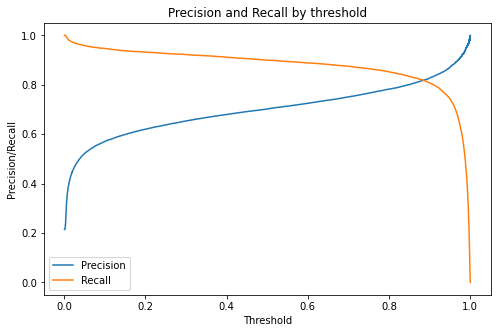

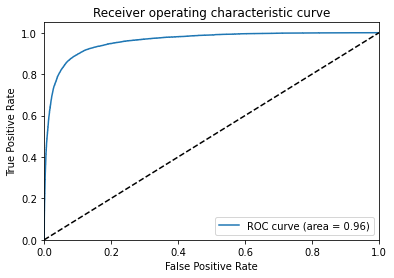

In [25]:
# Optimal threshold  설정 : Recall과 Precision을 가장 높게하는 지점 파악

precision_rt, recall_rt, threshold_rt = precision_recall_curve(pd.DataFrame(y_val)[1], ict_prob)
fpr, tpr, thresholds = metrics.roc_curve(pd.DataFrame(y_val)[1], ict_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision') 
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.title('Precision and Recall by threshold')
plt.legend() 
plt.show() 

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show() 

In [26]:
pr = precision_rt + recall_rt
index_cnt=np.where(pr==max(pr))

In [29]:
# Best Position of Threshold
#index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]

print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# Fixed Threshold 
# *주의* : 학습시 최적 임계치는 때마다 달라질 수 있음. 임계치 후 학습 모델 적용시 해당 임계치로 문서 분류에 적용해야함 
threshold_fixed = threshold_rt[index_cnt]
model_name = 'Trained_HAN_'+user_name+'_'+version_name+'_'+str(threshold_fixed)[1:7]
print('threshold: ',threshold_fixed) 

precision:  [0.81483676] , recall:  [0.82214491]
threshold:  [0.87738943]


In [ ]:
# 학습 모델 저장  : 모델명 뒤의 수치는 해당 모델의 threshold
# output type : 모델을 bin 파일로 저장

model.save('./model/{}'.format(model_name))

In [31]:
# ICT 예측값 (test set)
y_test_pred = np.argmax(model.predict(x_test), axis=1) 
y_test_ict_prob = model.predict(x_test)[:,1]

In [33]:
# 컨퓨젼 매트릭스 출력

pred_y = [ 1 if e> threshold_fixed else 0 for e in y_test_ict_prob] 
print(classification_report(pd.DataFrame(y_test)[1], pred_y))  
print(confusion_matrix(pd.DataFrame(y_test)[1], pred_y)) 

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     44941
           1       0.71      0.90      0.79     12265

    accuracy                           0.90     57206
   macro avg       0.84      0.90      0.86     57206
weighted avg       0.91      0.90      0.90     57206

[[40360  4581]
 [ 1227 11038]]


### (4) HAN을 통한 NTIS 예측 결과 확인 

In [ ]:
last = pd.DataFrame(y_test)
last['predicted'] = pred_y
last['ICT_PROB'] =y_test_ict_prob

In [ ]:
result_df = pd.concat([ict_doc.iloc[ict_test_index],non_ict_doc.iloc[non_ict_test_index]])
result_df.reset_index(drop=True,inplace=True)
result_df = pd.merge(result_df, last, left_index=True, right_index=True, how='left')
result_df = result_df.sort_values(by='ICT_PROB', ascending=False)
# result_df = result_df[['L_type_1',      'M_type_1',      'L_type_2',      'M_type_2',
#             'L_type_3',      'M_type_3',      'M_L_type',      'M_M_type',
#                 'AP_1',          'AP_2',          'AP_3',     '6T_L_type',
#            '6T_M_type',       'ES_type','year','contents','for tokenizer',1,'predicted','ICT_PROB']]

In [ ]:
result_df 

In [ ]:
len(result_df)

In [43]:
result_df.to_excel("result_df.xlsx")